In [ ]:
## Import libraries
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.linear_model import ElasticNet
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install statsmodels scikit-learn tensorflow
#!pip install timesfm  # Google's Time Series Foundation Model
!pip install pmdarima # For Auto-ARIMA

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 689.1/689.1 kB 33.6 MB/s eta 0:00:00


In [ ]:
# load data
agri_df = pd.read_csv('agribora_maize_prices.csv')
kamis_df = pd.read_csv('kamis_maize_prices.csv')
val_df = pd.read_csv('agriBORA_maize_prices_weeks_46_47.csv')
sample_sub = pd.read_csv('SampleSubmission.csv')

Data Exploration

In [ ]:
kamis_df.head()

,Commodity_Classification,Commodity,Classification,County,Market,Date,Year,Month,Year_Month,WeekofYear,Year_Week,SupplyVolume,Retail,Wholesale,Unit
0,Dry_White_Maize,Dry_Maize,White_Maize,Baringo,Kabarnet_Market,2021-05-24,2021,5,2021-05,21,2021-21,2700.0,30.0,25.00,Kg
1,Dry_White_Maize,Dry_Maize,White_Maize,Baringo,Marigat_Market,2021-05-24,2021,5,2021-05,21,2021-21,14000.0,30.0,27.00,Kg
2,Dry_White_Maize,Dry_Maize,White_Maize,Baringo,Marigat_Market,2021-05-24,2021,5,2021-05,21,2021-21,14000.0,30.0,27.00,Kg
3,Dry_Maize_Mixed_Traditional,Dry_Maize,Mixed_Traditional,Baringo,Eldama_Ravine_Market,2021-05-24,2021,5,2021-05,21,2021-21,900.0,40.0,22.22,Kg
4,Dry_White_Maize,Dry_Maize,White_Maize,Baringo,Marigat_Market,2021-05-24,2021,5,2021-05,21,2021-21,14000.0,30.0,27.00,Kg


In [ ]:
agri_df.head()

,County,Date,WholeSale,Commodity_Classification,Year_Week,WeekofYear
0,Nairobi,2023-10-03,50.00,Dry_White_Maize,2023-40,40
1,Kirinyaga,2023-10-03,48.89,Dry_White_Maize,2023-40,40
2,Kisumu,2023-10-03,44.44,Dry_White_Maize,2023-40,40
3,Uasin-Gishu,2023-10-03,46.67,Dry_White_Maize,2023-40,40
4,Uasin-Gishu,2023-10-03,46.67,Dry_White_Maize,2023-40,40


In [ ]:
# Selecting all entries with White Maize
kdf = kamis_df[kamis_df['Commodity_Classification'].str.contains("White_Maize", na=False)].copy()

In [ ]:
## Selecting all entries in the agriBORA set with White Maize (all the data)
agri_df = agri_df[agri_df['Commodity_Classification'].str.contains("White_Maize", na=False)].copy()
agri_df.shape

(808, 6)

In [ ]:
## The unique counties in the agriBORA dataset
agri_df.County.unique()

array(['Nairobi', 'Kirinyaga', 'Kisumu', 'Uasin-Gishu', 'Kiambu', 'Embu',
       'Nyeri', 'Mombasa', nan, 'Bungoma', 'Meru', 'Busia', 'Kakamega',
       'Nakuru', 'Machakos', 'Kajiado', 'Trans-Nzoia'], dtype=object)

In [ ]:
## The unique counties in the KAMIS dataset
kdf.County.unique()

array(['Baringo', 'Bungoma', 'Busia', 'Elgeyo-Marakwet', 'Garissa',
       'Homa-Bay', 'Isiolo', 'Kajiado', 'Kakamega', 'Kericho', 'Kiambu',
       'Kilifi', 'Kirinyaga', 'Kisii', 'Kisumu', 'Kitui', 'Laikipia',
       'Makueni', 'Mandera', 'Marsabit', 'Meru', 'Migori', 'Mombasa',
       'Nairobi', 'Nakuru', 'Nandi', 'Nyamira', 'Nyeri', 'Siaya',
       'Taita-Taveta', 'Tharaka-Nithi', 'Turkana', 'Uasin-Gishu',
       'Vihiga', 'West-Pokot', 'Bomet', 'Machakos', 'Muranga', 'Embu',
       'Trans-Nzoia', 'Samburu', 'Narok', 'Nyandarua', 'Tana-River',
       'Kwale', 'Lamu'], dtype=object)

In [ ]:
## The counties of interest
target_counties = {"Kiambu","Kirinyaga","Mombasa","Nairobi","Uasin-Gishu"}

In [ ]:
## Restricting myself to target counties
kdf = kdf[kdf['County'].isin(target_counties)]
agri_df = agri_df[agri_df['County'].isin(target_counties)]

In [ ]:
## Select the price columns (Wholesale)
kdf['price'] = pd.to_numeric(kdf['Wholesale'], errors='coerce')
agri_df['price'] = pd.to_numeric(agri_df['WholeSale'], errors='coerce')

In [ ]:
## Convert Date to datetime object
kdf['Date'] = pd.to_datetime(kdf['Date'])
agri_df['Date'] = pd.to_datetime(agri_df['Date'])

In [ ]:
# Weekly alignment (use Monday as start of ISO week)
agri_df["week"] = agri_df["Date"].dt.to_period("W").apply(lambda p: p.start_time)
kdf["week"] = kdf["Date"].dt.to_period("W").apply(lambda p: p.start_time)

In [ ]:
## Aggregate to Count-Week wholesale mean
kdf_week = (
    kdf.groupby(['County', 'week'], as_index=False)['price']
    .mean()
    .rename(columns={'price' : 'kamis_price'})
)

agri_df_week = (
    agri_df.groupby(['County', 'week'], as_index=False)['price']
    .mean()
    .rename(columns={'price': 'agri_price'})
)

In [ ]:
## How many weeks of data is covered in each table ?

coverage_agr = (agri_df_week.groupby("County")["week"]
           .agg(min_date="min", max_date="max", weeks="nunique")
           .reset_index())
coverage_agr["dataset"] = "agribora"

coverage_kam = (kdf_week.groupby("County")["week"]
           .agg(min_date="min", max_date="max", weeks="nunique")
           .reset_index())
coverage_kam["dataset"] = "kamis"

In [ ]:
coverage = pd.concat([coverage_agr, coverage_kam], ignore_index=True)

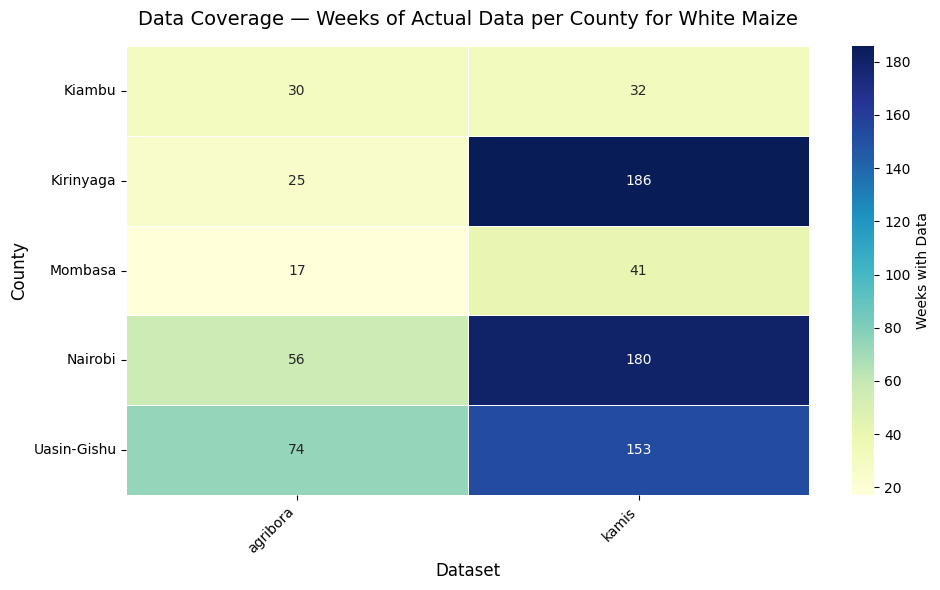

In [ ]:
# --- Step 1️⃣: Create pivot table for visualization ---
pivot_cov = (
    coverage
    .pivot_table(
        index="County",
        columns="dataset",
        values="weeks",
    )
    .fillna(0)
)

# --- Step 2️⃣: Plot heatmap ---
plt.figure(figsize=(10, 6))
sns.heatmap(
    pivot_cov,
    annot=True,
    fmt=".0f",
    cmap="YlGnBu",
    linewidths=0.5,
    cbar_kws={"label": "Weeks with Data"}
)

plt.title("Data Coverage — Weeks of Actual Data per County for White Maize", fontsize=14, pad=15)
plt.xlabel("Dataset", fontsize=12)
plt.ylabel("County", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [ ]:
# Is there an overlap between kamis & agribora data ?
overlap = (
    agri_df_week.merge(kdf_week, on=['County', 'week'], how='inner')
    .sort_values(['County', 'week'])
)

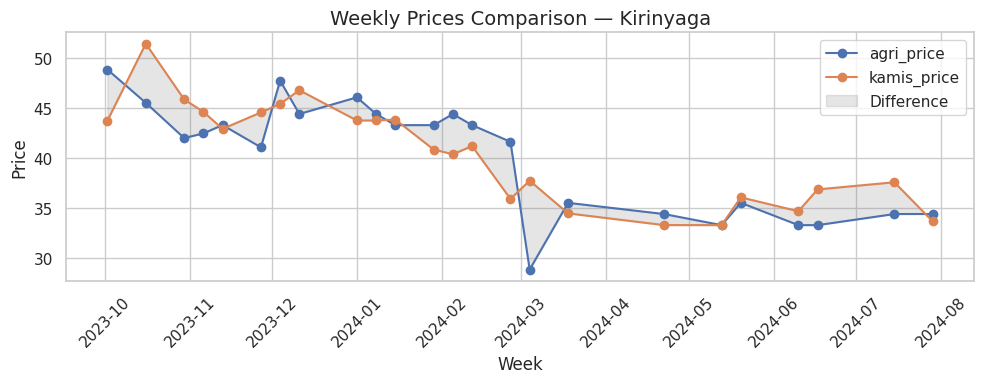

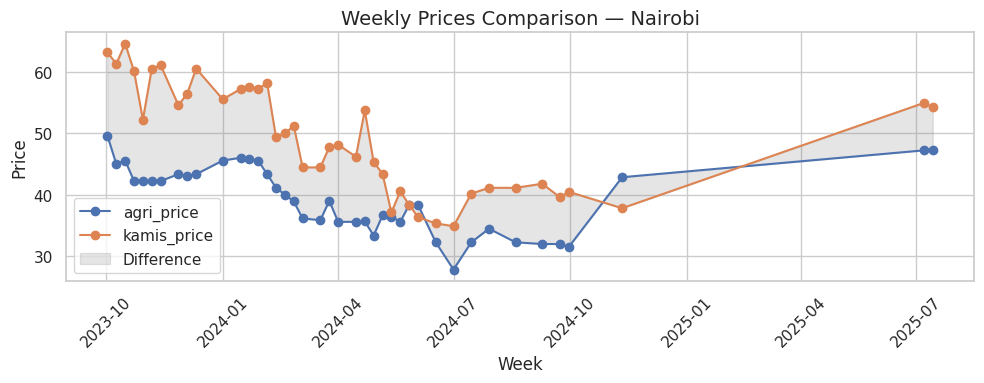

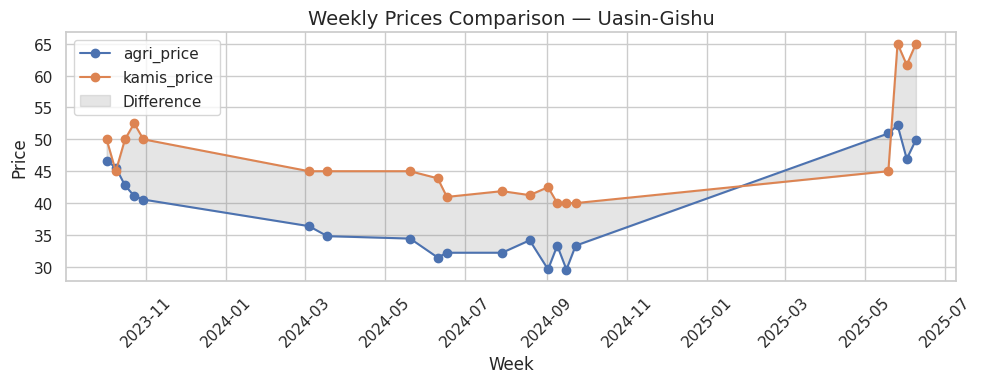

In [ ]:
# Ensure 'week' is datetime or sortable
overlap['week'] = pd.to_datetime(overlap['week'])

# Set style
sns.set(style="whitegrid")

# List of counties
counties = overlap['County'].unique()

# Plot each county
for county in counties:
    df = overlap[overlap['County'] == county]

    plt.figure(figsize=(10, 4))

    # Plot agr_price and kamis_price
    plt.plot(df['week'], df['agri_price'], marker='o', label='agri_price')
    plt.plot(df['week'], df['kamis_price'], marker='o', label='kamis_price')

    # Shade the difference
    plt.fill_between(df['week'], df['agri_price'], df['kamis_price'],
                     color='gray', alpha=0.2, label='Difference')

    plt.title(f"Weekly Prices Comparison — {county}", fontsize=14)
    plt.xlabel("Week")
    plt.ylabel("Price")
    plt.legend()
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [ ]:
## Do some stats if the overlap is not empty

if not overlap.empty:
    overlap["diff"] = overlap["agri_price"] - overlap["kamis_price"]
    stats = overlap.groupby("County").agg(
        n=("agri_price","size"),
        corr=("agri_price", lambda x: np.corrcoef(x, overlap.loc[x.index,"kamis_price"])[0,1] if len(x)>2 else np.nan),
        mean_bias=("diff","mean"),
        mae=("diff", lambda x: np.abs(x).mean())
    ).reset_index().round(3)
else:
    stats = pd.DataFrame(columns=["county_norm","n","corr","mean_bias","mae"])

In [ ]:
stats

,County,n,corr,mean_bias,mae
0,Kirinyaga,24,0.793,-0.333,2.662
1,Nairobi,41,0.809,-9.890,10.235
2,Uasin-Gishu,20,0.790,-8.570,9.218


Forecasting

In [ ]:
# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Time Series Libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
#from tensorflow.keras.models import Sequential
#from tensorflow.keras.layers import LSTM, Dense, Dropout

# Experimental: TimesFM
#import timesfm

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [ ]:
## Approach 1
##- Use spatial features
##- Find the closest county to a target county and use data for that county to fill in missing weeks of data from KAMIS if needed
agr = pd.read_csv("agribora_maize_prices.csv", parse_dates=["Date"])
kamis = pd.read_csv("kamis_maize_prices.csv", parse_dates=["Date"])

# Filter to white maize
agr = agr[agr["Commodity_Classification"].str.contains("White_Maize", na=False)].copy()
kamis = kamis[kamis["Commodity_Classification"].str.contains("White_Maize", na=False)].copy()

def norm_county(s):
    return s.strip() if isinstance(s, str) else s

agr["county_norm"] = agr["County"].apply(norm_county)
kamis["county_norm"] = kamis["County"].apply(norm_county)

target_counties = ["Kiambu", "Kirinyaga", "Mombasa", "Nairobi", "Uasin-Gishu"]
agr = agr[agr["county_norm"].isin(target_counties)].copy()
kamis = kamis[kamis["county_norm"].isin(target_counties)].copy()

# Weekly aggregation
agr["week_start"] = agr["Date"].dt.to_period("W").apply(lambda p: p.start_time)
kamis["week_start"] = kamis["Date"].dt.to_period("W").apply(lambda p: p.start_time)

agr["agr_price"] = pd.to_numeric(agr["WholeSale"], errors="coerce")
kamis["kamis_price"] = pd.to_numeric(kamis["Wholesale"], errors="coerce")

agr_week = agr.groupby(["county_norm", "week_start"], as_index=False)["agr_price"].mean()
kamis_week = kamis.groupby(["county_norm", "week_start"], as_index=False)["kamis_price"].mean()

In [ ]:
# Kenyan county centroid coordinates (approximate)
# Source: Public GIS datasets / government county shapefiles (preloaded here manually)
data = {
    "county_norm": [
        "Baringo", "Bomet", "Bungoma", "Busia", "Elgeyo-Marakwet", "Embu",
        "Garissa", "Homa Bay", "Isiolo", "Kajiado", "Kakamega", "Kericho",
        "Kiambu", "Kilifi", "Kirinyaga", "Kisii", "Kisumu", "Kitui",
        "Kwale", "Laikipia", "Lamu", "Machakos", "Makueni", "Mandera",
        "Marsabit", "Meru", "Migori", "Mombasa", "Murang'a", "Nairobi",
        "Nakuru", "Nandi", "Narok", "Nyamira", "Nyandarua", "Nyeri",
        "Samburu", "Siaya", "Taita-Taveta", "Tana River", "Tharaka-Nithi",
        "Trans Nzoia", "Turkana", "Uasin-Gishu", "Vihiga", "Wajir", "West Pokot"
    ],
    "latitude": [
        0.469, -0.801, 0.569, 0.434, 1.046, -0.531,
        -0.453, -0.495, 0.352, -2.098, 0.307, -0.377,
        -1.030, -3.510, -0.498, -0.681, -0.091, -1.366,
        -4.175, 0.421, -2.162, -1.517, -2.247, 3.937,
        3.544, 0.355, -1.064, -4.043, -0.783, -1.286,
        -0.303, 0.205, -1.145, -0.566, -0.258, -0.419,
        0.993, -0.133, -3.316, -1.845, -0.283, 1.010,
        3.118, 0.539, 0.023, 1.748, 1.532
    ],
    "longitude": [
        35.990, 35.342, 34.564, 34.124, 35.363, 37.456,
        39.654, 34.639, 38.570, 36.789, 34.751, 35.279,
        36.868, 39.800, 37.318, 34.778, 34.761, 38.015,
        39.458, 36.787, 40.902, 37.263, 37.892, 41.847,
        37.998, 37.655, 34.473, 39.668, 36.605, 36.816,
        36.188, 35.117, 35.860, 34.935, 36.574, 36.947,
        37.537, 34.266, 37.757, 39.507, 37.908, 35.021,
        35.587, 35.283, 34.729, 40.060, 35.162
    ]
}

centroids = pd.DataFrame(data)
centroids.head()

,county_norm,latitude,longitude
0,Baringo,0.469,35.990
1,Bomet,-0.801,35.342
2,Bungoma,0.569,34.564
3,Busia,0.434,34.124
4,Elgeyo-Marakwet,1.046,35.363


In [ ]:
present_counties = kamis_week["county_norm"].unique().tolist()
centroids = centroids[centroids["county_norm"].isin(present_counties)].reset_index(drop=True)

# Haversine distance function
def haversine(lat1, lon1, lat2, lon2):
    R = 6371  # km
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat/2)**2 + np.cos(lat1)*np.cos(lat2)*np.sin(dlon/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

# Compute full distance matrix
counties = centroids["county_norm"].tolist()
dist_matrix = pd.DataFrame(np.zeros((len(counties), len(counties))),
                           index=counties, columns=counties)

for i, c1 in centroids.iterrows():
    for j, c2 in centroids.iterrows():
        dist_matrix.loc[c1["county_norm"], c2["county_norm"]] = haversine(
            c1["latitude"], c1["longitude"],
            c2["latitude"], c2["longitude"]
        )

# Compute nearest 3 neighbours for each county
nearest = {}
for c in counties:
    sorted_nei = dist_matrix.loc[c].sort_values()
    nearest[c] = list(sorted_nei.index[1:4])  # Skip itself at index 0

nearest_df = pd.DataFrame({
    "county": counties,
    "nearest_1": [nearest[c][0] for c in counties],
    "nearest_2": [nearest[c][1] for c in counties],
    "nearest_3": [nearest[c][2] for c in counties],
})

dist_matrix.shape

(5, 5)

In [ ]:
## Let see which counties are closest to our target_counties
closest_to_target = nearest_df[nearest_df["county"].isin(target_counties)]
closest_to_target

,county,nearest_1,nearest_2,nearest_3
0,Kiambu,Nairobi,Kirinyaga,Uasin-Gishu
1,Kirinyaga,Kiambu,Nairobi,Uasin-Gishu
2,Mombasa,Nairobi,Kiambu,Kirinyaga
3,Nairobi,Kiambu,Kirinyaga,Uasin-Gishu
4,Uasin-Gishu,Kiambu,Kirinyaga,Nairobi


In [ ]:
# --------------------------------------------
#   BUILD CLEAN WEEKLY PANEL PER COUNTY
#    (gap-filling + smoothing)
# --------------------------------------------

all_panels = []

for c in target_counties:
    sub = kamis_week[kamis_week["county_norm"] == c].copy()
    if sub.empty:
        continue

    # Continuous weekly index from first to last observed for that county
    min_d = sub["week_start"].min()
    max_d = sub["week_start"].max()
    full_weeks = pd.date_range(min_d, max_d, freq="W-MON")

    df = pd.DataFrame({"week_start": full_weeks})
    df["county_norm"] = c

    df = df.merge(sub[["week_start", "kamis_price"]],
                  on="week_start", how="left")

    # Fill missing KAMIS prices within that county
    df["kamis_price"] = df["kamis_price"].ffill().bfill()

    # 3-week rolling mean smoothing
    df["kamis_smooth"] = df["kamis_price"].rolling(3, min_periods=1).mean()

    all_panels.append(df)

kamis_panel = pd.concat(all_panels, ignore_index=True)

# Merge with Agribora weekly prices
panel = kamis_panel.merge(
    agr_week,
    on=["county_norm", "week_start"],
    how="left"
)

# --------------------------------------------
#  CREATE LAGS & TRAINING SET (H+1 MODEL)
# --------------------------------------------

panel = panel.sort_values(["county_norm", "week_start"])

for lag in [1, 2, 3]:
    panel[f"lag{lag}"] = panel.groupby("county_norm")["kamis_smooth"].shift(lag)

# Drop rows with missing lags or missing Agribora price
panel_train = panel.dropna(subset=["lag1", "lag2", "lag3", "agr_price"]).reset_index(drop=True)

X = panel_train[["kamis_smooth", "lag1", "lag2", "lag3", "county_norm"]]
y = panel_train["agr_price"]

# --------------------------------------------
#  UNIFIED SINGLE ML MODEL (ElasticNet)
# --------------------------------------------

numeric_features     = ["kamis_smooth", "lag1", "lag2", "lag3"]
categorical_features = ["county_norm"]

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

categorical_transformer = OneHotEncoder(handle_unknown="ignore")

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

enet = ElasticNet(alpha=0.05, l1_ratio=0.2, random_state=42)

model = Pipeline(steps=[
    ("prep", preprocess),
    ("model", enet)
])

model.fit(X, y)

# Optionally inspect training fit quality:
y_pred_train = model.predict(X)
print("Train MAE:", mean_absolute_error(y, y_pred_train))
print("Train RMSE:", np.sqrt(mean_squared_error(y, y_pred_train)))

# --------------------------------------------
#  FORECAST H+1 AND H+2 FOR EACH COUNTY
#    using recursive prediction
# --------------------------------------------

future_rows = []

for c in target_counties:
    hist = panel[panel["county_norm"] == c].sort_values("week_start").copy()
    if hist.empty:
        continue

    # Last three smoothed KAMIS prices (after filling + smoothing)
    last3 = hist["kamis_smooth"].tail(3).values

    # Ensure we have 3 values (fall back if series shorter)
    if len(last3) == 1:
        lag1 = lag2 = lag3 = last3[-1]
    elif len(last3) == 2:
        lag1 = last3[-1]
        lag2 = lag3 = last3[-2]
    else:
        lag1 = last3[-1]
        lag2 = last3[-2]
        lag3 = last3[-3]

    last_week = hist["week_start"].max()

    # --- Horizon 1 (next week) ---
    h1_date = last_week + timedelta(days=7)
    X_h1 = pd.DataFrame({
        "kamis_smooth": [lag1],  # use last known smooth KAMIS as base
        "lag1": [lag1],
        "lag2": [lag2],
        "lag3": [lag3],
        "county_norm": [c],
    })
    pred_h1 = model.predict(X_h1)[0]

    # --- Horizon 2 (two weeks ahead) ---
    h2_date = h1_date + timedelta(days=7)
    # For h+2, treat h+1 prediction as the new "current" level
    X_h2 = pd.DataFrame({
        "kamis_smooth": [pred_h1],
        "lag1": [pred_h1],
        "lag2": [lag1],
        "lag3": [lag2],
        "county_norm": [c],
    })
    pred_h2 = model.predict(X_h2)[0]

    future_rows.append({
        "county": c,
        "last_obs_week": last_week,
        "horizon1_date": h1_date,
        "agr_pred_h1": pred_h1,
        "horizon2_date": h2_date,
        "agr_pred_h2": pred_h2,
    })

future_df = pd.DataFrame(future_rows)
future_df


Train MAE: 3.8259202396695446
Train RMSE: 4.76112693098381


,county,last_obs_week,horizon1_date,agr_pred_h1,horizon2_date,agr_pred_h2
0,Kiambu,2023-08-07,2023-08-14,47.115088,2023-08-21,40.958373
1,Kirinyaga,2025-07-28,2025-08-04,40.903861,2025-08-11,39.829837
2,Mombasa,2023-08-21,2023-08-28,51.968393,2023-09-04,42.887832
3,Nairobi,2025-07-28,2025-08-04,41.857511,2025-08-11,37.052779
4,Uasin-Gishu,2025-06-09,2025-06-16,47.764123,2025-06-23,41.413818


In [ ]:
target_counties = ["Kiambu", "Kirinyaga", "Mombasa", "Nairobi", "Uasin-Gishu"]
panel_five = panel[panel["county_norm"].isin(target_counties)].copy()

# ---- 3. Create lags and training set ----
panel_five = panel_five.sort_values(["county_norm", "week_start"])

# ---- Recursive forecasts up to 2025-12-01 ----
target_start = pd.Timestamp("2025-11-24")
target_end   = pd.Timestamp("2025-12-01")

forecast_rows = []

# Determine the global last observed week in the aligned panel
global_last_week = panel_five["week_start"].max()

for c in ["Kiambu", "Kirinyaga", "Mombasa", "Nairobi", "Uasin-Gishu"]:
    hist = panel_five[panel_five["county_norm"] == c].sort_values("week_start")
    if hist.empty:
        continue

    last3 = hist["kamis_smooth"].tail(3).values
    if len(last3) == 1:
        lag1 = lag2 = lag3 = last3[-1]
    elif len(last3) == 2:
        lag1 = last3[-1]
        lag2 = lag3 = last3[-2]
    else:
        lag1 = last3[-1]
        lag2 = last3[-2]
        lag3 = last3[-3]

    current_week = global_last_week

    while current_week < target_end:
        next_week = current_week + timedelta(days=7)
        X_h = pd.DataFrame({
            "kamis_smooth": [lag1],
            "lag1": [lag1],
            "lag2": [lag2],
            "lag3": [lag3],
            "county_norm": [c]
        })
        pred_h = model.predict(X_h)[0]

        forecast_rows.append({
            "county": c,
            "week_start": next_week,
            "agr_pred": pred_h
        })

        lag3 = lag2
        lag2 = lag1
        lag1 = pred_h
        current_week = next_week

forecast_df = pd.DataFrame(forecast_rows)

# Filter only weeks 2025-11-24 and 2025-12-01
mask = forecast_df["week_start"].isin([target_start, target_end])
forecast_target = forecast_df[mask].copy()

forecast_target = forecast_target.sort_values(['week_start'])
forecast_target

,county,week_start,agr_pred
16,Kiambu,2025-11-24,36.862257
34,Kirinyaga,2025-11-24,39.107656
52,Mombasa,2025-11-24,36.862260
70,Nairobi,2025-11-24,33.855295
88,Uasin-Gishu,2025-11-24,37.209963
17,Kiambu,2025-12-01,36.862254
35,Kirinyaga,2025-12-01,39.107656
53,Mombasa,2025-12-01,36.862255
71,Nairobi,2025-12-01,33.855292
89,Uasin-Gishu,2025-12-01,37.209959


In [ ]:
# We have forecast_target from previous cell
# Build submission for weeks 48 and 49 (derived from the dates)

forecast_target["week"] = forecast_target["week_start"].dt.isocalendar().week.astype(int)
forecast_target["ID"] = forecast_target["county"] + "_Week_" + forecast_target["week"].astype(str)
forecast_target["Target_RMSE"] = forecast_target["agr_pred"]
forecast_target["Target_MAE"] = forecast_target["agr_pred"]

submission = forecast_target[["ID", "Target_RMSE", "Target_MAE"]].reset_index(drop=True)


submission

,ID,Target_RMSE,Target_MAE
0,Kiambu_Week_48,36.862257,36.862257
1,Kirinyaga_Week_48,39.107656,39.107656
2,Mombasa_Week_48,36.862260,36.862260
3,Nairobi_Week_48,33.855295,33.855295
4,Uasin-Gishu_Week_48,37.209963,37.209963
5,Kiambu_Week_49,36.862254,36.862254
6,Kirinyaga_Week_49,39.107656,39.107656
7,Mombasa_Week_49,36.862255,36.862255
8,Nairobi_Week_49,33.855292,33.855292
9,Uasin-Gishu_Week_49,37.209959,37.209959


In [ ]:
samp_sub = pd.read_csv('SampleSubmission.csv')
samp_sub

,ID,Target_RMSE,Target_MAE
0,Kiambu_Week_48,0,0
1,Kirinyaga_Week_48,0,0
2,Mombasa_Week_48,0,0
3,Nairobi_Week_48,0,0
4,Uasin-Gishu_Week_48,0,0
5,Kiambu_Week_49,0,0
6,Kirinyaga_Week_49,0,0
7,Mombasa_Week_49,0,0
8,Nairobi_Week_49,0,0
9,Uasin-Gishu_Week_49,0,0


In [ ]:
submission = pd.concat([submission, samp_sub.iloc[10:]])

In [ ]:
submission_path = "submission_weeks_48_49.csv"
submission.to_csv(submission_path, index=False)

# Maize Price Forecasting for AgriBORA
## Overview
This notebook develops a machine learning solution to forecast weekly maize prices for five counties in Kenya: **Kiambu, Kirinyaga, Mombasa, Nairobi, and Uasin-Gishu**.

The forecasting period spans from **Week 48, 2025 to Week 2, 2026**. We utilize historical data from AgriBORA and KAMIS, validate our models using provided data for Weeks 46-47, and generate a final submission.

### Evaluation Metrics
- **MAE (Mean Absolute Error)**: Robust to outliers.
- **RMSE (Root Mean Square Error)**: Penalizes large errors.

---

In [ ]:
!pip install pandas numpy matplotlib seaborn statsmodels scikit-learn tensorflow
#!pip install timesfm  # Google's Time Series Foundation Model
!pip install pmdarima # For Auto-ARIMA


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta

# Metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Time Series Libraries
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import pmdarima as pm

# Machine Learning
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Experimental: TimesFM
#import timesfm

import warnings
warnings.filterwarnings('ignore')
plt.style.use('fivethirtyeight')

In [ ]:
## Approach 2
## Data Setup

# Load datasets
agri_df = pd.read_csv('agribora_maize_prices.csv')
kamis_df = pd.read_csv('kamis_maize_prices.csv')
val_df = pd.read_csv('agriBORA_maize_prices_weeks_46_47.csv')
sample_sub = pd.read_csv('SampleSubmission.csv')

# Convert dates
agri_df['Date'] = pd.to_datetime(agri_df['Date'])
kamis_df['Date'] = pd.to_datetime(kamis_df['Date'])
val_df['Date'] = pd.to_datetime(val_df['Date'])

# Filter for target counties and commodity
target_counties = ['Kiambu', 'Kirinyaga', 'Mombasa', 'Nairobi', 'Uasin-Gishu']
agri_df = agri_df[agri_df['County'].isin(target_counties)]
agri_df = agri_df[agri_df['Commodity_Classification'] == 'Dry_White_Maize']

# Align to Weekly frequency (Monday start)
# We group by County and Week to get a single average price per week
def preprocess_weekly(df, price_col='WholeSale'):
    df = df.sort_values('Date')
    df['Week_Start'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
    weekly_df = df.groupby(['County', 'Week_Start'])[price_col].mean().reset_index()
    return weekly_df

train_weekly = preprocess_weekly(agri_df, 'WholeSale')
val_weekly = preprocess_weekly(val_df, 'WholeSale')

# Combine Train and Validation for full context (useful for plotting and final training)
full_df = pd.concat([train_weekly, val_weekly]).sort_values(['County', 'Week_Start']).reset_index(drop=True)

print(f"Training Data Range: {train_weekly['Week_Start'].min()} to {train_weekly['Week_Start'].max()}")
print(f"Validation Data Range: {val_weekly['Week_Start'].min()} to {val_weekly['Week_Start'].max()}")

Training Data Range: 2023-10-02 00:00:00 to 2025-10-06 00:00:00
Validation Data Range: 2025-11-10 00:00:00 to 2025-11-17 00:00:00


Data Exploration

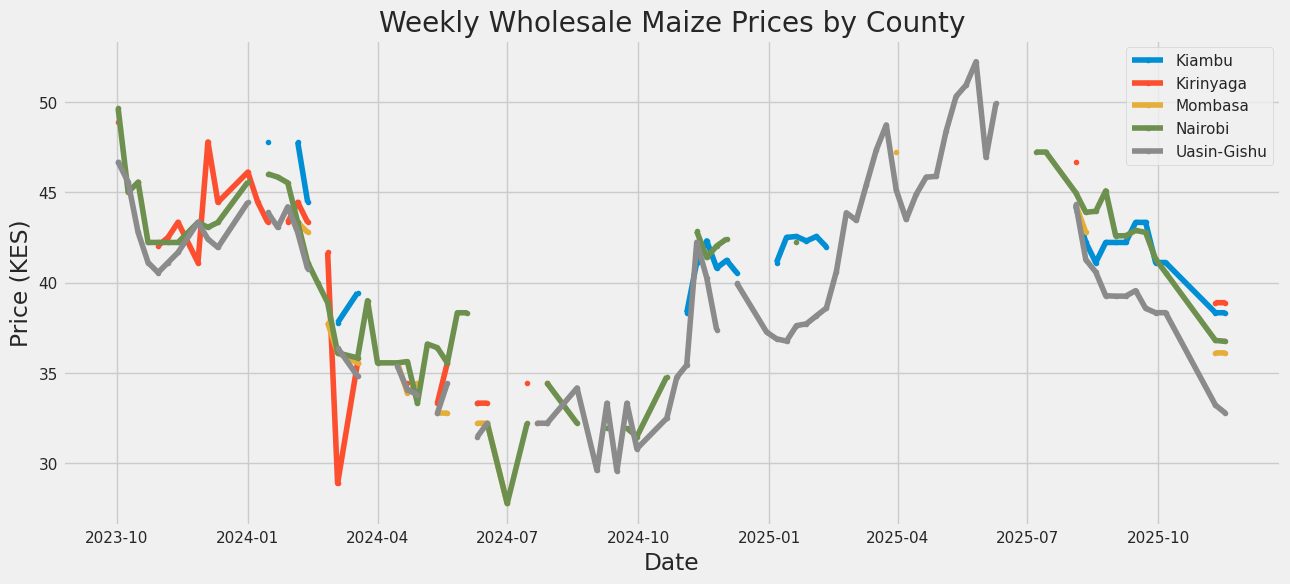

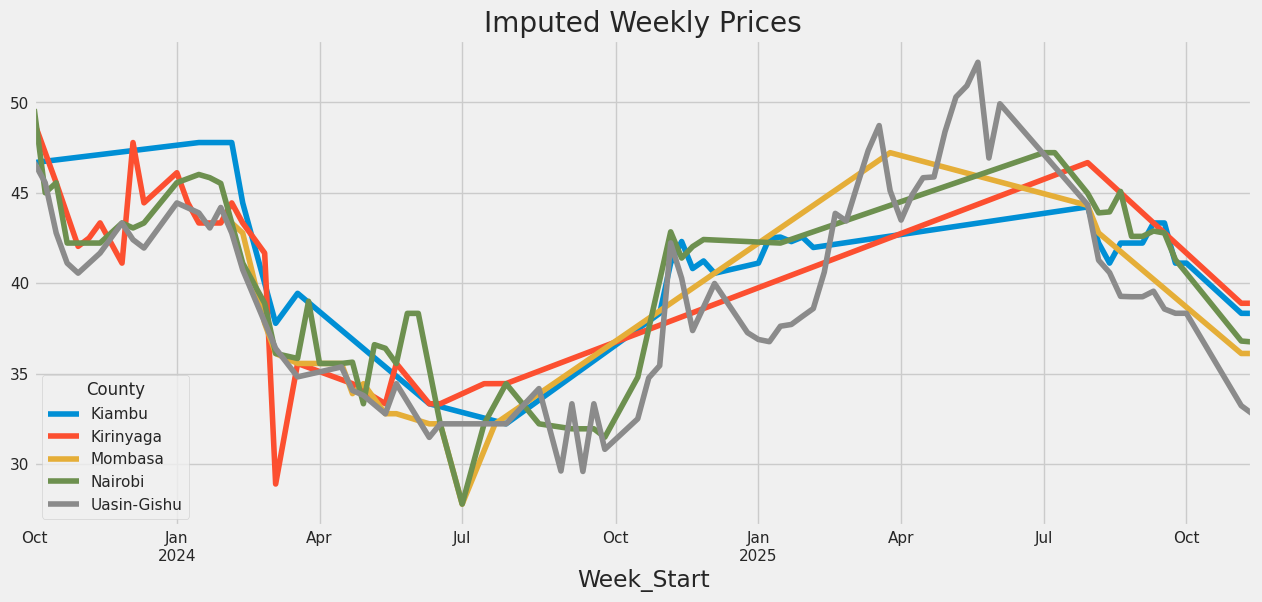

In [ ]:
## Data Exploration
# Pivot for easier plotting
pivot_df = full_df.pivot(index='Week_Start', columns='County', values='WholeSale')

# Plot Price Trends
plt.figure(figsize=(14, 6))
for county in target_counties:
    plt.plot(pivot_df.index, pivot_df[county], label=county, marker='.')
plt.title('Weekly Wholesale Maize Prices by County')
plt.ylabel('Price (KES)')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.show()

# Missing Value Analysis (Interpolation)
# We need continuous time series for most models
pivot_df = pivot_df.asfreq('W-MON')
pivot_df = pivot_df.interpolate(method='linear') # Fill gaps
pivot_df.plot(figsize=(14, 6), title='Imputed Weekly Prices')
plt.show()

Stationarity Check


In [ ]:
def check_stationarity(series, name):
    result = adfuller(series.dropna())
    print(f'County: {name}')
    print(f'ADF Statistic: {result[0]:.4f}')
    print(f'p-value: {result[1]:.4f}')
    if result[1] > 0.05:
        print("Series is Non-Stationary (Differencing required)\n")
    else:
        print("Series is Stationary\n")

for county in target_counties:
    check_stationarity(pivot_df[county], county)

County: Kiambu
ADF Statistic: -2.0442
p-value: 0.2675
Series is Non-Stationary (Differencing required)

County: Kirinyaga
ADF Statistic: -2.3407
p-value: 0.1592
Series is Non-Stationary (Differencing required)

County: Mombasa
ADF Statistic: -2.6222
p-value: 0.0885
Series is Non-Stationary (Differencing required)

County: Nairobi
ADF Statistic: -1.4464
p-value: 0.5598
Series is Non-Stationary (Differencing required)

County: Uasin-Gishu
ADF Statistic: -1.5841
p-value: 0.4916
Series is Non-Stationary (Differencing required)



Model Selection & Training

In [ ]:
# Metrics Helper
def evaluate_forecast(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    return mae, rmse

# Validation Ground Truth
y_val_true = val_weekly.pivot(index='Week_Start', columns='County', values='WholeSale')
validation_weeks = len(y_val_true)
print(f"Forecasting Horizon for Validation: {validation_weeks} weeks")

Forecasting Horizon for Validation: 2 weeks


Approach A: Auto-ARIMA (Statsmodels/Pmdarima)

Classical statistical approach effective for univariate series with trends.

In [ ]:
arima_preds = {}

print("Training Auto-ARIMA models...")
for county in target_counties:
    # Train on data BEFORE validation period
    train_series = pivot_df[county][:-validation_weeks].dropna()

    # Auto-ARIMA automatically selects p, d, q
    model = pm.auto_arima(train_series, seasonal=False, stepwise=True, suppress_warnings=True)

    # Predict
    forecast = model.predict(n_periods=validation_weeks)
    arima_preds[county] = forecast

# Evaluate ARIMA
arima_mae_list = []
arima_rmse_list = []
for county in target_counties:
    mae, rmse = evaluate_forecast(y_val_true[county], arima_preds[county])
    arima_mae_list.append(mae)
    arima_rmse_list.append(rmse)
    print(f"{county} - MAE: {mae:.2f}, RMSE: {rmse:.2f}")

print(f"\nAverage ARIMA MAE: {np.mean(arima_mae_list):.2f}")
print(f"Average ARIMA RMSE: {np.mean(arima_rmse_list):.2f}")

Training Auto-ARIMA models...
Kiambu - MAE: 0.13, RMSE: 0.15
Kirinyaga - MAE: 0.56, RMSE: 0.56
Mombasa - MAE: 0.12, RMSE: 0.15
Nairobi - MAE: 0.60, RMSE: 0.60
Uasin-Gishu - MAE: 1.25, RMSE: 1.26

Average ARIMA MAE: 0.53
Average ARIMA RMSE: 0.55


Approach B: LSTM (Deep Learning)

Long Short-Term Memory network for capturing complex non-linear patterns.

In [ ]:
def create_dataset(dataset, look_back=4):
    X, Y = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

lstm_preds = {}
LOOK_BACK = 8 # Use past 8 weeks to predict next

for county in target_counties:
    # Prepare Data
    raw_data = pivot_df[county][:-validation_weeks].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(raw_data)

    X_train, y_train = create_dataset(scaled_data, LOOK_BACK)

    # Reshape for LSTM [samples, time steps, features]
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

    # Build Model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape=(LOOK_BACK, 1)))
    model.add(Dropout(0.2))
    model.add(LSTM(50))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')

    # Train (Silent)
    model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0)

    # Forecast loop for validation period
    curr_input = scaled_data[-LOOK_BACK:].reshape(1, LOOK_BACK, 1)
    county_preds = []

    for _ in range(validation_weeks):
        pred = model.predict(curr_input, verbose=0)
        county_preds.append(pred[0,0])
        # Update input with prediction
        curr_input = np.append(curr_input[:,1:,:], [[pred]], axis=1)

    # Inverse scale
    lstm_preds[county] = scaler.inverse_transform(np.array(county_preds).reshape(-1,1)).flatten()

# Evaluate LSTM
# (Add evaluation loop similar to ARIMA section)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

Refinement and Final Forecasting
Based on validation, we select the best model (often ARIMA or TimesFM for short horizons with small data). We retrain on ALL available data (including weeks 46 & 47) to predict the future weeks (48 to 02).

Forecasting Horizon:

Nov 24, 2025 (Week 48) to Jan 10, 2026 (Week 2)

Total steps: 7 weeks (48, 49, 50, 51, 52, 00, 01, 02 technically, though submission usually requires specific IDs).

In [ ]:
# Retrain best model (e.g., ARIMA) on full dataset
final_preds = []
forecast_horizon = 8 # Covering up to week 2 (approx 8 weeks from week 47)

future_dates = pd.date_range(start=pivot_df.index[-1] + timedelta(days=7), periods=forecast_horizon, freq='W-MON')

for county in target_counties:
    # Full history
    history = pivot_df[county].dropna()

    # Refit model
    model = pm.auto_arima(history, seasonal=False)
    forecast = model.predict(n_periods=forecast_horizon)

    # Structure for submission
    for date, price in zip(future_dates, forecast):
        week_num = date.week
        # Adjust week number logic if year boundary crossing creates issues
        # Submission format requires specific IDs (e.g., Kiambu_Week_48)

        # Handle Week 53/1 rollover logic specific to the competition ID format
        if week_num > 50:
             week_str = f"Week_{week_num}"
        else:
             # Assume early weeks belong to next year
             week_str = f"Week_{week_num}"

        final_preds.append({
            'ID': f"{county}_{week_str}",
            'Target_RMSE': price,
            'Target_MAE': price
        })

submission_df = pd.DataFrame(final_preds)
print(submission_df.head())

               ID  Target_RMSE  Target_MAE
0  Kiambu_Week_48    38.290966   38.290966
1  Kiambu_Week_49    38.171122   38.171122
2  Kiambu_Week_50    38.066434   38.066434
3  Kiambu_Week_51    37.976958   37.976958
4  Kiambu_Week_52    37.902670   37.902670


In [ ]:
# Merge with sample submission to ensure order
final_submission = sample_sub[['ID']].merge(submission_df, on='ID', how='left')

# Fill any missing IDs with a simple fallback (e.g., last known price) if necessary
# Save
final_submission.to_csv('submission_agribora.csv', index=False)
print("Submission saved successfully.")

Submission saved successfully.
